In [35]:
%load_ext autoreload
%autoreload 2

import logging

# LOG CONFIGURATIONS and FORMATTING
DEFAULT_FORMAT = (
    "[%(levelname)1.1s %(asctime)s %(module)s:%(lineno)d] %(message)s"
)
DEFAULT_FORMAT = (
    "[%(levelname)1.1s %(asctime)s] %(message)s"
)
formatter = logging.Formatter(fmt=DEFAULT_FORMAT)

# Get the root logger
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)  # Set the global logging level

# Configure the console handler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)

# Add the handler to the root logger
if not root_logger.handlers:  # Avoid adding multiple handlers
    root_logger.addHandler(console_handler)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Sensing Entities
The entities of the SensorThings API's Sensing component are illustrated in the following figure.

<img src="img/STA_schema.png" width="800">

To maintain proper references between elements, you must create them in a specific order:

1. Thing
2. Location
3. ObservedProperty
4. Sensor
5. Datastream
6. Observation (+FeatureOfInterest)



# STA API time-travel extension
This extension assists istSTA users in accessing historical time travel data. It enables users to retrieve information from a web service as it appeared at a specific moment in time, using a new query parameter called **as_of**.

Additionally, it introduces a new entity called Commit, which enables data lineage, allowing users to trace data changes. 
From a scientific perspective, this extension enables FAIR data management by allowing datasets to be permanently cited. This is achieved by using a combination of the service address (<font color='red'>in red</font>), the request that returns the dataset (<font color='green'>in green</font>), and the dataset's status at a specific time instant (<font color='orange'>in orange</font>) as a Persistent Identifier for reference.

Example: <font color='red'>https://&lt;base_url&gt;/&lt;version&gt;/</font><font color='green'>&lt;entity&gt;?$expand=&lt;entity&gt;</font><font color='orange'>&\$as_of=&lt;date_time&gt;</font>

## Definition
The *time-travel* extension adds the following optional query parameters to any STA request:

| Parameter | Type               | Description                                                                       |
| --------- | ------------------ | --------------------------------------------------------------------------------- |
| *as_of*   | ISO 8601 date-time | a date-time parameter to specify the exact moment for which the data is requested |
| *from_to* | ISO 8601 period    | a period parameter to specify the time interval for which the data is requested   |

The *time-travel* extension introduces a new entity, Commit, with the following properties:

| Properties     | Type               | Multiplicity and use | Description                                                                    |
| -------------- | ------------------ | -------------------- | ------------------------------------------------------------------------------ |
| *author*       | string             | One (mandatory)      | Authority, Username or User Profile Link                                       |
| *encodingType* | string             | One (optional)       | The encoding type of the message (default is `text`).                          |
| *message*      | string             | One (mandatory)      | Commit message detailing the scope, motivation, and method of the transaction. |
| *actionType*   | string             | One (mandatory)      | The action typer that applied the modifications (INSERT, UPDATE or DELETE)     |
| *date*         | ISO 8601 date-time | One (mandatory)      | A date-time that specifies the exact moment when the commit was executed.      |

Commits are related to SensorThings API entities with a one-to-zero-or-one (1:0..1) relationship.

### Preliminary Steps

This section contains the preliminary steps to set up the base URL, headers, and import necessary libraries.

In [28]:
!pip install saqc


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [36]:
import requests
from concurrent.futures import ThreadPoolExecutor
import json
import re
import utils as st
from IPython.display import display, Markdown
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import csv
from saqc import SaQC
import pandas as pd
import numpy as np
# Reinitialize logging to enforce your configuration
logging.getLogger().handlers = []  # Clear any existing handlers
logging.basicConfig(
    level=logging.DEBUG,
    format=DEFAULT_FORMAT,
    handlers=[console_handler],
)
# base url
base_url = "https://istsos.org/v4/v1.1/"

In [3]:
STA = st.sta(base_url, verbose=True)

### 1. Create an account and get the TOKEN

Answer to the questions, better in lowercase. Please do not spaces or spacial chars like (e.g. *ç" etc.)

In [183]:
# Set your name to have a prefix to had to the station name
username = input("Enter your username: ")
password = input("Enter your password: ")
uri = input("Enter your uri (e.g. ORCID): ")
if STA.create_user(username, password, uri=uri, role="editor"):
    token_obj = STA.get_token(username, password)
    logging.info(f"Token expires at: {token_obj['expires_in']} s")
# Set the prefix
prefix = username + "_"
logging.info("Your station name will be prefixed with: " + prefix)

[W 2024-11-20 11:17:26,797] User already exists
[I 2024-11-20 11:17:26,893] Token expires at: 1732100246 s
[I 2024-11-20 11:17:26,895] Your station name will be prefixed with: y_


### Creating multiple related entities with deep insert

In [11]:
body = {
    "description": "Meteo station recording temperature, humidity, and pressure",
    "name": prefix + "BED",
    "properties": {
        "keywords": "weather,station,temperature,humidity,pressure",
        "description": "Meteo station recording temperature, humidity, and pressure",
    },
    "Locations": [
        {
            "description": "Location of the BED meteo station",
            "name": prefix + "BED",
            "location": {
                "type": "Point",
                "coordinates": [8.510919, 46.505456],
            },
            "encodingType": "application/vnd.geo+json",
        }
    ],
    "Datastreams": [
        {
            "unitOfMeasurement": {
                "name": prefix + "Celsius degree",
                "symbol": "°C",
                "definition": "",
            },
            "description": "Temperature measurement",
            "name": prefix + "T_BED",
            "observationType": "",
            "ObservedProperty": {
                "name": prefix + "atmosphere:temperature",
                "definition": "",
                "description": "Air temperature",
            },
            "Sensor": {
                "description": "Temperature sensor",
                "name": prefix + "TempSensor",
                "encodingType": "application/json",
                "metadata": '{"brand": "SensorBrand", "type": "Temperature sensor"}',
            }
        },
        {
            "unitOfMeasurement": {
                "name": prefix + "Percentage",
                "symbol": "%",
                "definition": "",
            },
            "description": "Humidity measurement",
            "name": prefix + "H_BED",
            "observationType": "",
            "ObservedProperty": {
                "name": prefix + "atmosphere:humidity",
                "definition": "",
                "description": "Air humidity",
            },
            "Sensor": {
                "description": "Humidity sensor",
                "name": prefix + "HumiditySensor",
                "encodingType": "application/json",
                "metadata": '{"brand": "SensorBrand", "type": "Humidity sensor"}',
            }
        },
        {
            "unitOfMeasurement": {
                "name": prefix + "Millimiters",
                "symbol": "mm",
                "definition": "",
            },
            "description": "Pressure measurement",
            "name": prefix + "P_BED",
            "observationType": "",
            "ObservedProperty": {
                "name": prefix + "atmosphere:rain",
                "definition": "",
                "description": "Rain quantity",
            },
            "Sensor": {
                "description": "Pluviometer sensor",
                "name": prefix + "PluviometerSensor",
                "encodingType": "application/json",
                "metadata": '{"brand": "SensorBrand", "type": "Pluviometer sensor"}',
            }
        },
    ],
}

STA.create_thing(body, commit_message="Create the BED station")

<Response [201]>

### Insert Observations from CSV

In [ ]:
files = os.listdir("data")
for _file in files:
    logging.info("data" + os.sep + f"{_file}")
    datastream_name = _file.split(".")[0]
    dt = STA.query_api(
        "Datastreams", {"$filter": f"name eq '{prefix}{datastream_name}'"}
    )
    STA.csv2sta("data" + os.sep + f"{_file}", dt[0]["@iot.id"], max_rows=30000)

[I 2024-11-20 08:39:14,836] data/T_BED.csv
[I 2024-11-20 08:39:14,872] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=name+eq+'y_T_BED'
[W 2024-11-20 08:39:18,687] {"code":400,"type":"error","message":"Missing required property 'unique_observation_phenomenontime_datastreamid'"}
[W 2024-11-20 08:39:22,472] {"code":400,"type":"error","message":"Missing required property 'unique_observation_phenomenontime_datastreamid'"}
[I 2024-11-20 08:39:22,476] data/P_BED.csv
[I 2024-11-20 08:39:22,510] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=name+eq+'y_P_BED'
[W 2024-11-20 08:39:25,103] {"code":400,"type":"error","message":"Missing required property 'unique_observation_phenomenontime_datastreamid'"}
[I 2024-11-20 08:39:25,105] data/H_BED.csv
[I 2024-11-20 08:39:25,139] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=name+eq+'y_H_BED'
[W 2024-11-20 08:39:28,774] {"code":400,"type":"error","message":"Missing required property 'unique_observation_phenomenontime_datastreamid'"}
[W 20

In [48]:
# GET the things based on the prefix using the function startswith


thing = STA.query_api(
    "Things", {"$filter": f"startswith(name,'{prefix}_')"}
)
thing_id = thing[0]["@iot.id"]
json_data = (json.dumps(thing, indent=2))
md = f"```json\n{json_data}\n```"
display(Markdown(md))

[I 2024-11-20 09:26:45,097] URL: https://istsos.org/v4/v1.1/Things?$filter=startswith(name,'y__')


```json
[
  {
    "@iot.id": 2,
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(2)",
    "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Locations",
    "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/HistoricalLocations",
    "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Datastreams",
    "name": "yyy_BED",
    "description": "Meteo station recording temperature, humidity, and rain",
    "properties": {
      "keywords": "weather,station,temperature,humidity,pressure",
      "description": "Meteo station recording temperature, humidity, and pressure"
    },
    "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Commit(72)"
  },
  {
    "@iot.id": 3,
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(3)",
    "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(3)/Locations",
    "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(3)/HistoricalLocations",
    "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(3)/Datastreams",
    "name": "yyyy_BED",
    "description": "Meteo station recording temperature, humidity, and pressure",
    "properties": {
      "keywords": "weather,station,temperature,humidity,pressure",
      "description": "Meteo station recording temperature, humidity, and pressure"
    },
    "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(3)/Commit(10)"
  },
  {
    "@iot.id": 5,
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(5)",
    "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(5)/Locations",
    "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(5)/HistoricalLocations",
    "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(5)/Datastreams",
    "name": "y_BED",
    "description": "Meteo station recording temperature, humidity, and pressure",
    "properties": {
      "keywords": "weather,station,temperature,humidity,pressure",
      "description": "Meteo station recording temperature, humidity, and pressure"
    },
    "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(5)/Commit(12)"
  }
]
```

### Update with time-travel extension

#### Retrieve Thing (With the as_of value set to the date of the request)

#### Update Thing

In [49]:
body = {
    "description": "Meteo station recording temperature, humidity, and rain"
}
datetime_update = datetime.now()
STA.update_thing(thing_id, body, commit_message="updated description")

<Response [200]>

#### Retrieve Thing with Commit properties

In [58]:
r = STA.query_api(f"Things({thing_id})", {"$expand": "Commit"})
md = f"```json\n{json.dumps(r, indent=2)}\n```"
display(Markdown(md))

[I 2024-11-20 09:31:34,337] URL: https://istsos.org/v4/v1.1/Things(2)?$expand=Commit


```json
{
  "@iot.id": 2,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(2)",
  "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Locations",
  "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/HistoricalLocations",
  "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Datastreams",
  "name": "yyy_BED",
  "description": "Meteo station recording temperature, humidity, and rain",
  "properties": {
    "keywords": "weather,station,temperature,humidity,pressure",
    "description": "Meteo station recording temperature, humidity, and pressure"
  },
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Commit(73)",
  "Commit": {
    "date": "2024-11-20T08:27:31Z",
    "author": "y",
    "@iot.id": 73,
    "message": "updated description",
    "actionType": "UPDATE",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(73)"
  },
  "@iot.as_of": "2024-11-20T08:31:34Z"
}
```

#### Retrieve Thing at a specific instant (with the as_of value set to one minute prior to the update date)

In [88]:
tmp_datetime = datetime_update - timedelta(hours=1, seconds=1)
tmp_datetime = tmp_datetime.isoformat() + "Z"

r = STA.query_api(
    f"Things({thing_id})",
    {"$expand": "Commit", "$as_of": tmp_datetime}
)
md = f"```json\n{json.dumps(r, indent=2)}\n```"
display(Markdown(md))

[I 2024-11-20 09:58:36,158] URL: https://istsos.org/v4/v1.1/Things(2)?$expand=Commit&$as_of=2024-11-20T08:27:30.287622Z


```json
{
  "@iot.id": 2,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(2)?$as_of=value: 2024-11-20T08:27:30.287622Z",
  "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Locations?$as_of=value: 2024-11-20T08:27:30.287622Z",
  "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/HistoricalLocations?$as_of=value: 2024-11-20T08:27:30.287622Z",
  "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Datastreams?$as_of=value: 2024-11-20T08:27:30.287622Z",
  "name": "yyy_BED",
  "description": "Meteo station recording temperature, humidity, and rain",
  "properties": {
    "keywords": "weather,station,temperature,humidity,pressure",
    "description": "Meteo station recording temperature, humidity, and pressure"
  },
  "systemTimeValidity": "2024-11-20T08:07:37Z/2024-11-20T08:27:31Z",
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(2)/Commit(72)",
  "Commit": {
    "date": "2024-11-20T08:07:37Z",
    "author": "y",
    "@iot.id": 72,
    "message": "updated description",
    "actionType": "UPDATE",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(72)"
  },
  "@iot.as_of": "2024-11-20T08:27:30.287622Z"
}
```

### FROM CSV TO DATAFRAME

In [ ]:
files = os.listdir("data")
for _file in files:
    logging.info("data" + os.sep + f"{_file}")
    
    df = pd.read_csv("data" + os.sep + f"{_file}")
    break

data/T_BED.csv


### FROM SensorThings API to Dataframe

In [91]:
# Copyright (c) 2024 SUPSI
# 
# This software is released under the MIT License.
# https://opensource.org/licenses/MIT

dfs, qcs = STA.get_dfs_by_datastreams(f"startswith(name,'{prefix}')")

[I 2024-11-20 10:04:29,008] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=startswith(name,'y_')
[I 2024-11-20 10:04:29,010] Datastream: yyy_T_BED
[I 2024-11-20 10:04:29,012] Description: Temperature measurement
[I 2024-11-20 10:04:29,013] Unit of measurement: yyy_Celsius degree (°C)
[I 2024-11-20 10:04:29,051] URL: https://istsos.org/v4/v1.1/Datastream(4)/Observations?$top=15000&$orderby=phenomenonTime asc
[I 2024-11-20 10:04:29,052] Number of observations: 0
[I 2024-11-20 10:04:29,052] 

[I 2024-11-20 10:04:29,053] --------------------
[I 2024-11-20 10:04:29,053] Datastream: yyy_H_BED
[I 2024-11-20 10:04:29,054] Description: Humidity measurement
[I 2024-11-20 10:04:29,054] Unit of measurement: yyy_Percentage (%)
[I 2024-11-20 10:04:29,169] URL: https://istsos.org/v4/v1.1/Datastream(5)/Observations?$top=15000&$orderby=phenomenonTime asc
[I 2024-11-20 10:04:29,172] Number of observations: 0
[I 2024-11-20 10:04:29,172] 

[I 2024-11-20 10:04:29,173] --------------------
[I 2024-11-2

### Plot the data

/tmp/ipykernel_34943/3886337611.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}"
/tmp/ipykernel_34943/3886337611.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}"
/tmp/ipykernel_34943/3886337611.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}"


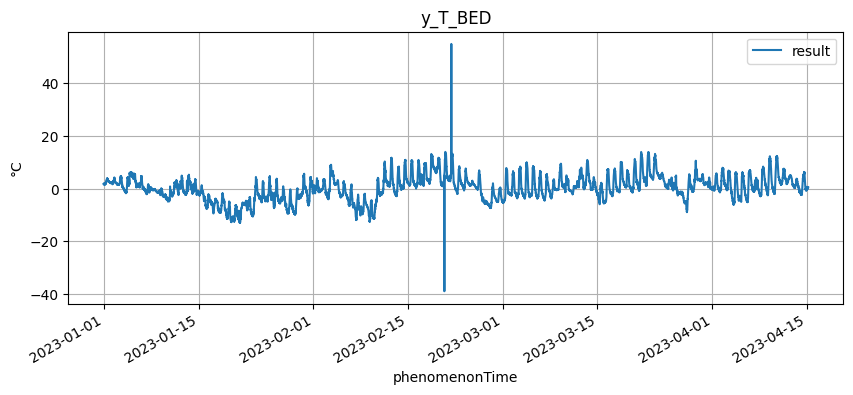

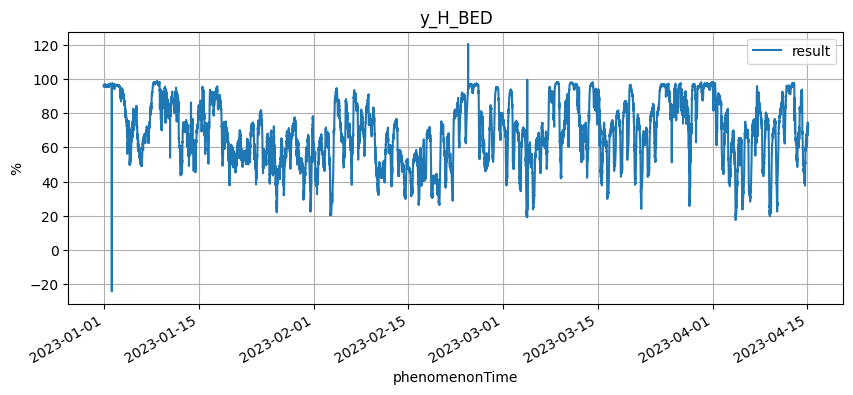

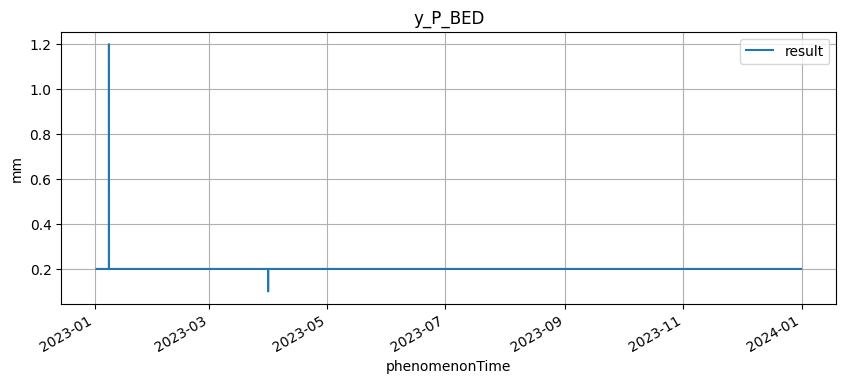

In [93]:
for df in dfs:
    dfs[df].plot(
        y="result",
        title=df,
        figsize=(10, 4),
        grid=True,
        ylabel=f"{dfs[df]['ylabel'][0]}"
    )

### Some quality checks examples

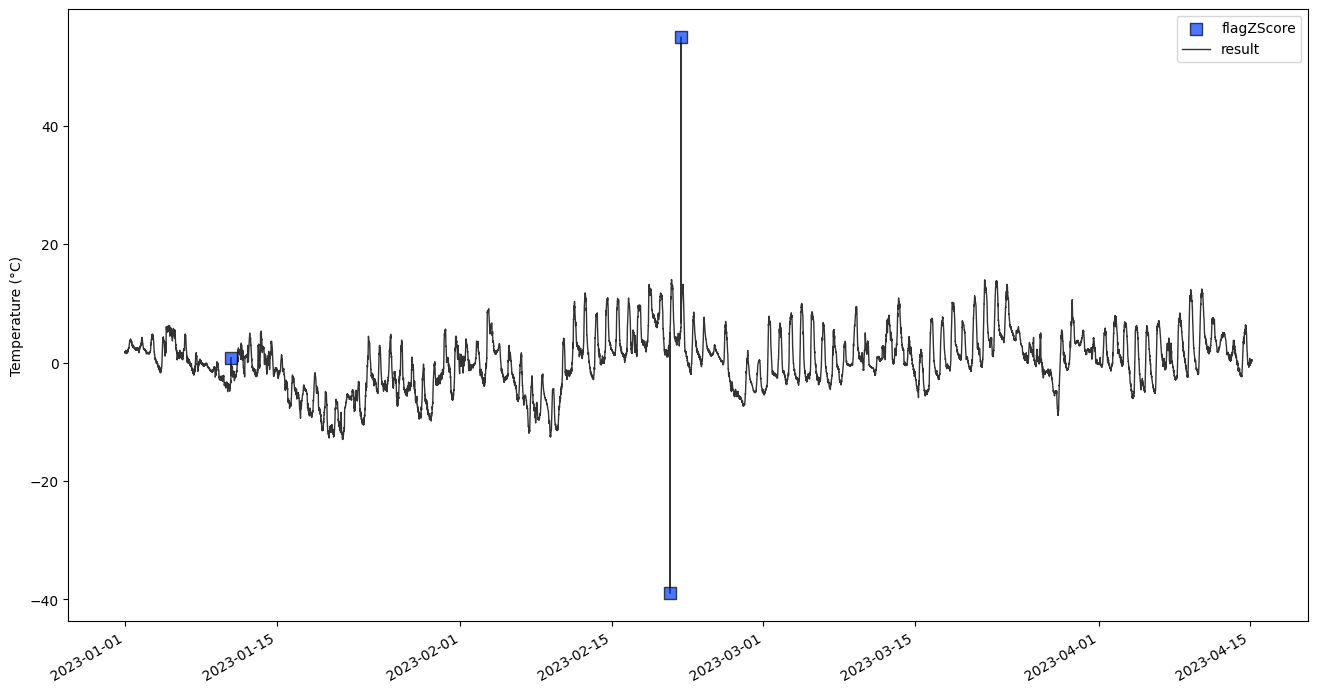

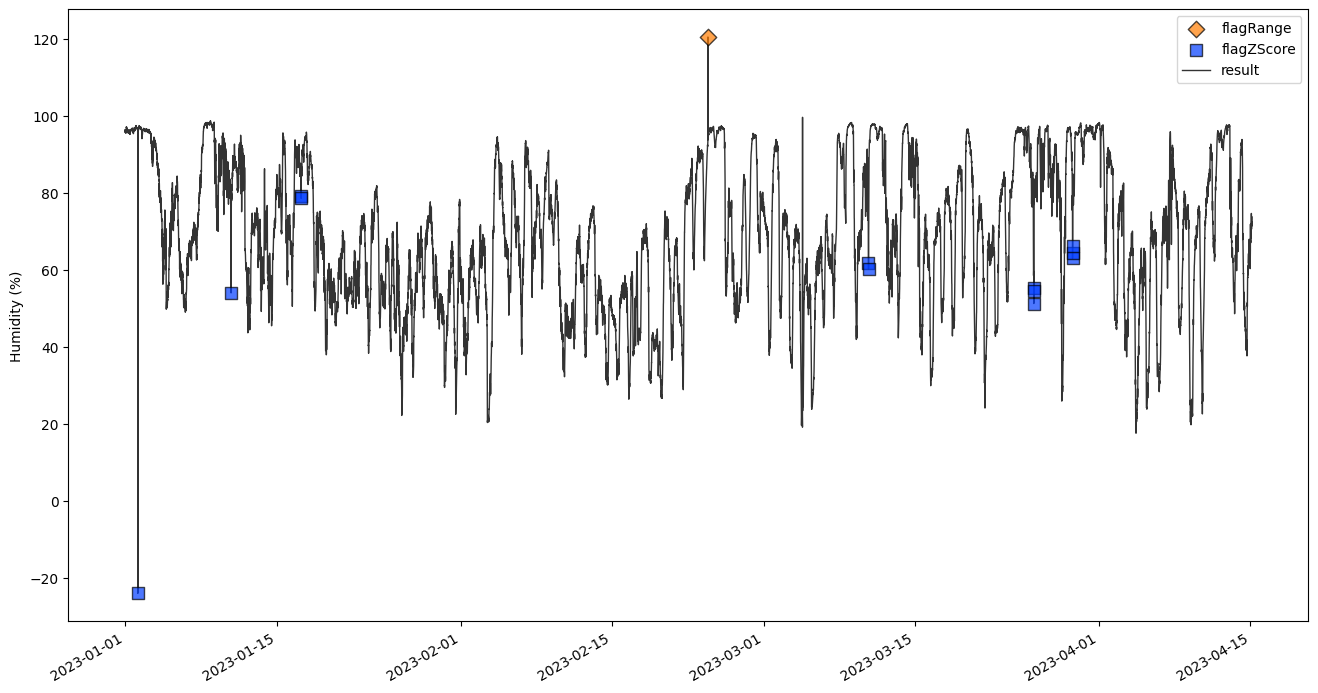

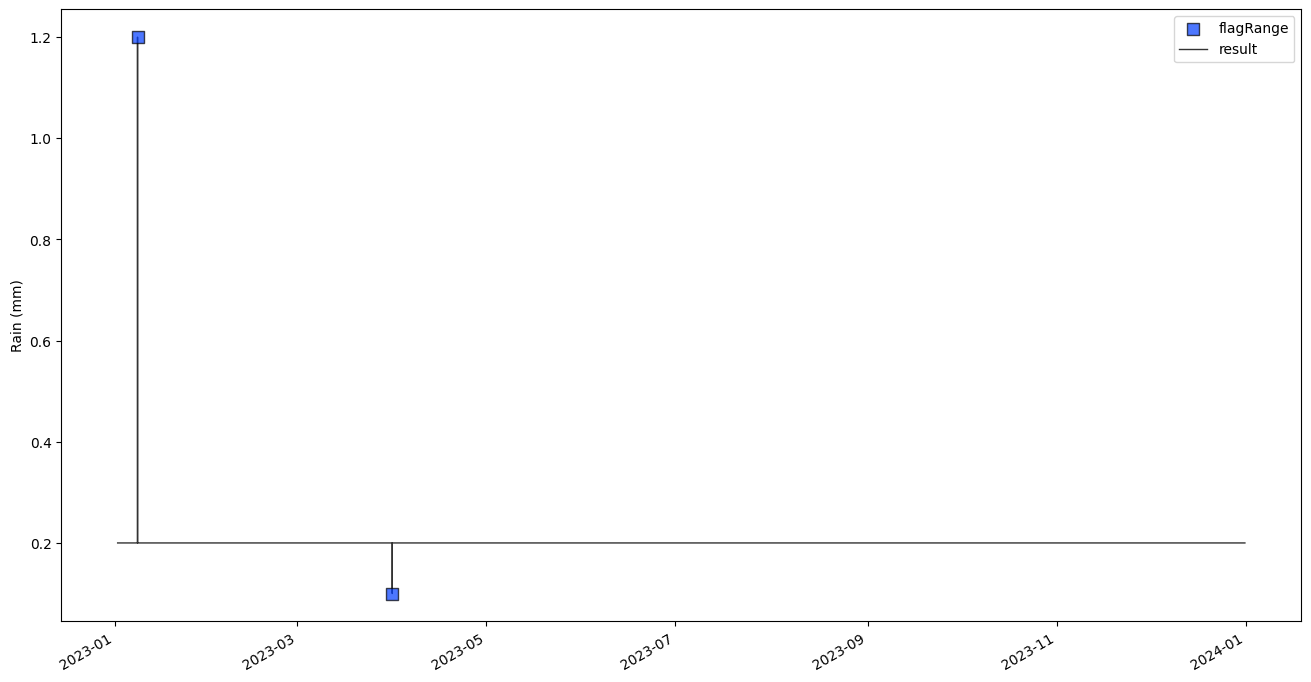

In [133]:
for _qc in qcs:
    if "_T_" in _qc:
        qc = (
            qcs[_qc]
            .flagMissing("result", flag=90)
            .flagConstants("result", thresh=0.1, window="1D", flag=91)
            .flagZScore("result", window="1D", flag=92)
            .flagRange("result", min=-20, max=50, flag=93)
        )
        dfs[_qc].loc[qc.flags["result"] == 90, "resultQuality"] = 90
        dfs[_qc].loc[qc.flags["result"] == 91, "resultQuality"] = 91
        dfs[_qc].loc[qc.flags["result"] == 92, "resultQuality"] = 92
        dfs[_qc].loc[qc.flags["result"] == 93, "resultQuality"] = 93
        qc.plot(
            "result",
            ax_kwargs={
                "ylabel": f"Temperature (°C)",
            },
        )
        dfs[_qc].update
    elif "_H_" in _qc:
        qc = (
            qcs[_qc]
            .flagMissing("result", flag=90)
            .flagConstants("result", thresh=0.1, window="1D", flag=91)
            .flagZScore("result", window="1D", flag=92)
            .flagRange("result", min=0, max=100, flag=93)
        )
        dfs[_qc].loc[qc.flags["result"] == 90, "resultQuality"] = 90
        dfs[_qc].loc[qc.flags["result"] == 91, "resultQuality"] = 91
        dfs[_qc].loc[qc.flags["result"] == 92, "resultQuality"] = 92
        dfs[_qc].loc[qc.flags["result"] == 93, "resultQuality"] = 93
        qc.plot(
            "result",
            ax_kwargs={
                "ylabel": f"Humidity (%)",
            },
        )
    else:
        qc = (
            qcs[_qc]
            .flagMissing("result", flag=90)
            .flagRange("result", min=0.2, max=0.2, flag=91)
        )
        dfs[_qc].loc[qc.flags["result"] == 90, "resultQuality"] = 90
        dfs[_qc].loc[qc.flags["result"] == 91, "resultQuality"] = 91
        qc.plot(
            "result",
            ax_kwargs={
                # "figsize": (10, 4),
                # "grid": True,
                "ylabel": f"Rain (mm)",
            },
        )

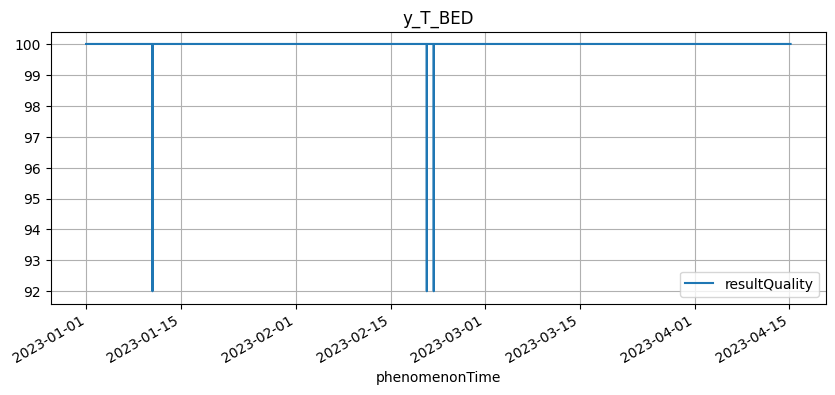

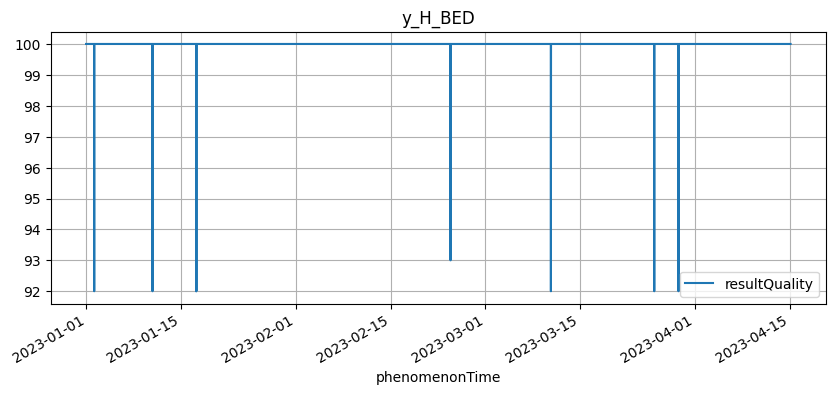

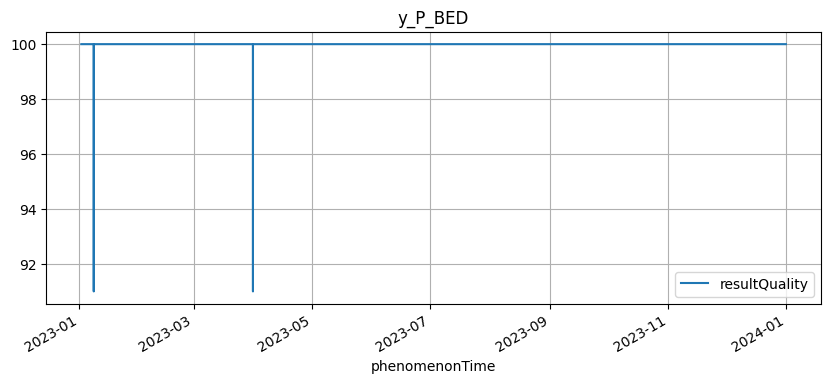

In [135]:
for _df in dfs:
    dfs[_df].plot(y="resultQuality", title=_df, figsize=(10, 4), grid=True)

In [189]:
for df in dfs:
    for row in dfs[df].loc[dfs[df]["resultQuality"]<100].itertuples():
        body = {
            "resultQuality": str(row[8])
        }
        STA.update_observation(row[1], body, commit_message="Quality flagging")
    print(f"Observations of Datastream {df} updated")


Observations of Datastream y_T_BED updated
Observations of Datastream y_H_BED updated
Observations of Datastream y_P_BED updated


#### Update Observation outlier

#### Retrieve Observation after update

In [195]:
datetime_obs_update = datetime.now()
for df in dfs:
    for row in dfs[df].loc[dfs[df]["resultQuality"]<100].itertuples():
        response = STA.query_api(f"Observations({row[1]})?$expand=Commit", travel_time=True)
        json_data = json.dumps(response, indent=2)
        md = f"```json\n{json_data}\n```"
        display(Markdown(md))
        break
    break

[I 2024-11-20 11:23:33,836] URL: https://istsos.org/v4/v1.1/Observations(68417)?$expand=Commit


```json
{
  "@iot.id": 68417,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Observations(68417)",
  "FeatureOfInterest@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(68417)/FeatureOfInterest",
  "Datastream@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(68417)/Datastream",
  "phenomenonTime": "2023-01-10T19:00:00Z",
  "resultTime": "2023-01-10T19:00:00Z",
  "result": 0.83,
  "resultQuality": 92,
  "validTime": null,
  "parameters": null,
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(68417)/Commit(113)",
  "Commit": {
    "date": "2024-11-20T10:19:08Z",
    "author": "y",
    "@iot.id": 113,
    "message": "Quality flagging",
    "actionType": "UPDATE",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(113)"
  },
  "@iot.as_of": "2024-11-20T10:23:33Z"
}
```

#### Retrieve Observation outlier at a specific instant (with the as_of value set to one second prior to the update date)

In [197]:
datetime_before_update = datetime_update - timedelta(hours=1, seconds=1)
datetime_before_update = datetime_before_update.isoformat() + "Z"
for df in dfs:
    for row in dfs[df].loc[dfs[df]["resultQuality"] < 100].itertuples():
        response = STA.query_api(
            f"Observations({row[1]})?$expand=Commit&$as_of={datetime_before_update}", travel_time=True
        )
        json_data = json.dumps(response, indent=2)
        md = f"```json\n{json_data}\n```"
        display(Markdown(md))
        break
    break

[I 2024-11-20 11:24:49,399] URL: https://istsos.org/v4/v1.1/Observations(68417)?$expand=Commit&$as_of=2024-11-20T08:27:30.287622Z


```json
{
  "@iot.id": 68417,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Observations(68417)?$as_of=value: 2024-11-20T08:27:30.287622Z",
  "FeatureOfInterest@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(68417)/FeatureOfInterest?$as_of=value: 2024-11-20T08:27:30.287622Z",
  "Datastream@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(68417)/Datastream?$as_of=value: 2024-11-20T08:27:30.287622Z",
  "phenomenonTime": "2023-01-10T19:00:00Z/2023-01-10T19:00:00Z",
  "resultTime": "2023-01-10T19:00:00Z",
  "result": 0.83,
  "resultQuality": 100,
  "validTime": null,
  "parameters": null,
  "systemTimeValidity": "2024-11-20T07:20:30Z/2024-11-20T10:18:29Z",
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(68417)/Commit(13)",
  "Commit": {
    "date": "2024-11-20T07:20:30Z",
    "author": "y",
    "@iot.id": 13,
    "message": "Insert observations",
    "actionType": "INSERT",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(13)"
  },
  "@iot.as_of": "2024-11-20T08:27:30.287622Z"
}
```

#### Plot Observations after update

/tmp/ipykernel_34943/3600024759.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}",
/tmp/ipykernel_34943/3600024759.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}",
/tmp/ipykernel_34943/3600024759.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}",


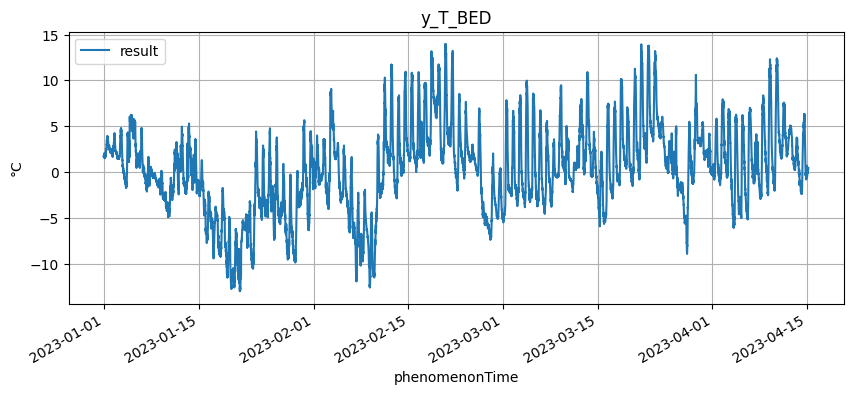

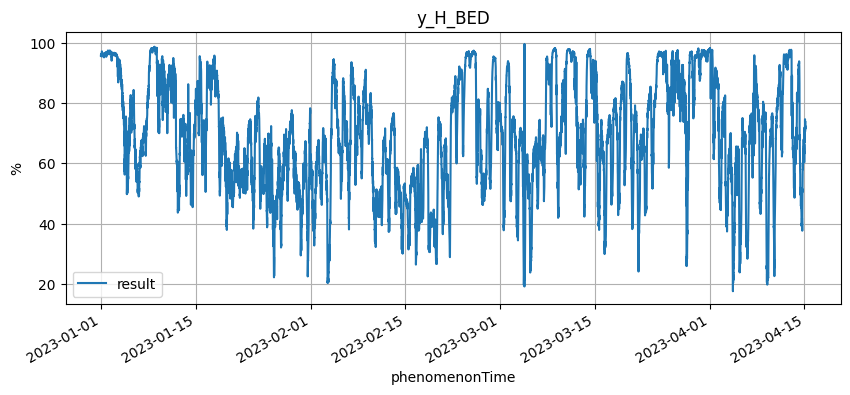

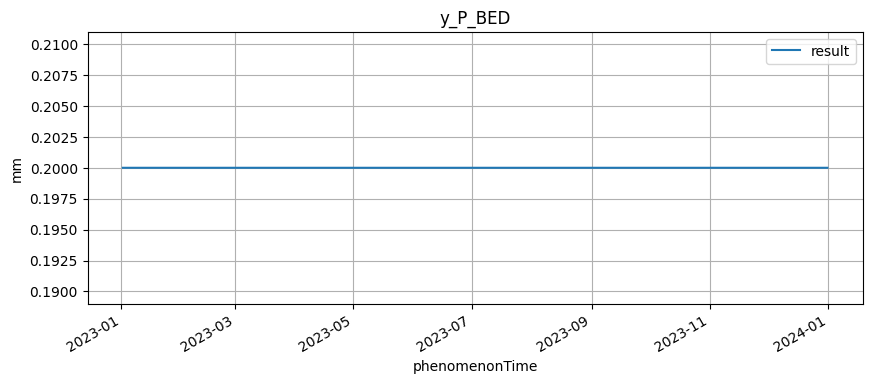

In [199]:
for df in dfs:
    dfs[df].loc[dfs[df]["resultQuality"] >= 100].plot(
        y="result",
        title=df,
        figsize=(10, 4),
        grid=True,
        ylabel=f"{dfs[df]['ylabel'][0]}",
    )

#### Retrieve Observation outlier within a time interval (between the date prior to the update and the date following it)

In [ ]:
response = requests.get(f"{base_url}Observations?$filter=id eq {observation_id}&$from_to={datetime_before_update}, {datetime_update}")
json_data = json.dumps(response.json(), indent=2)
md = f"```json\n{json_data}\n```"
display(Markdown(md))

/tmp/ipykernel_34943/4213695386.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}",
/tmp/ipykernel_34943/4213695386.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}",
/tmp/ipykernel_34943/4213695386.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}",


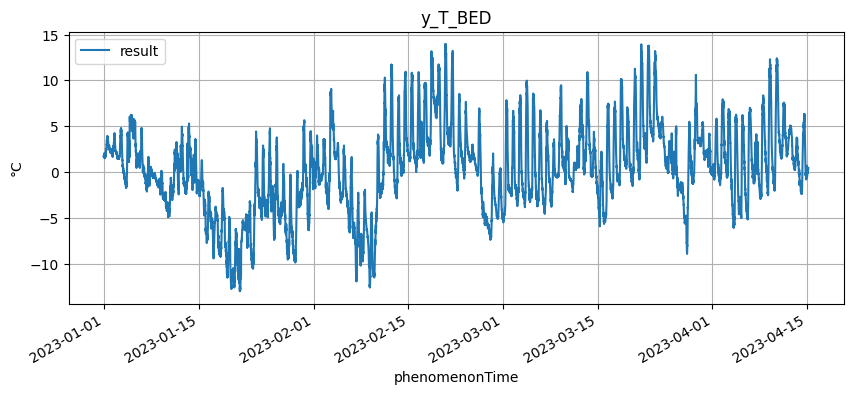

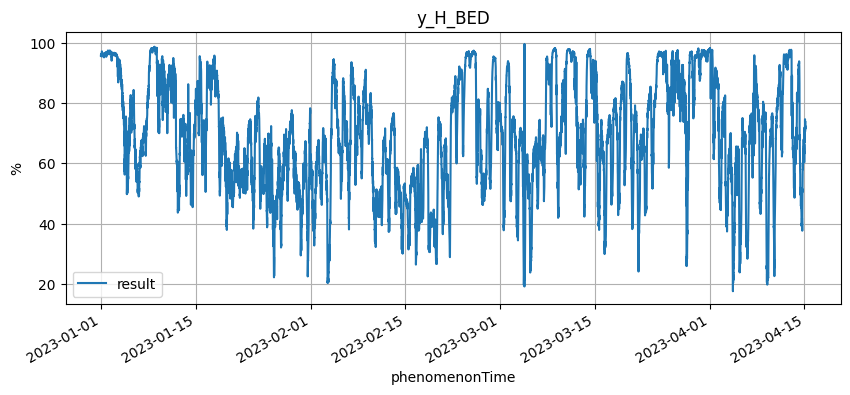

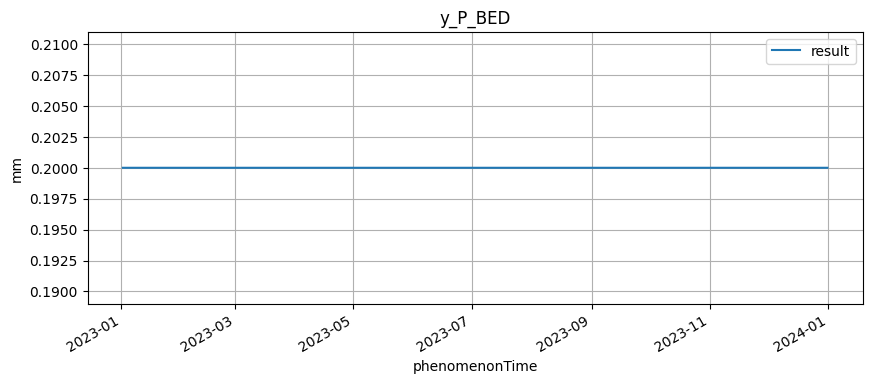